# Tarea M10 MPAD de Germán Fros

# Problema machine learning: **Predicción de puntos a final de temporada**


### Template para Desarrollo de Modelos siguiendo CRISP-DM

In [19]:
### Configuración Inicial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Importar más librerías según necesidad

pd.set_option('display.max_columns', None)

# 1. Comprensión del Proyecto

## Objetivo del Proyecto
Predecir la cantidad de puntos que un equipo acumulará al final de la temporada

## Contexto del Problema
La directiva de un club uruguayo, junto con su cuerpo técnico, desea diseñar una herramienta que le permita evaluar jornada a jornada el desempeño de su equipo y a qué posiciones en la tabla aspira a final de temporada basado en su rendimiento.

## Criterios de éxito
- MAE <= 6 puntos (≈ 2 partidos de diferencia);
- R² >= 0.6 (explica al menos el 60% de la variación en puntos)

## Supuestos y Restricciones
- Dudas sobre si es suficiente la cantidad de datos de partidos disponible (tres temporadas) para elaborar un modelo efectivo;
- Ver como se comporta con equipos los cuales tenemos menos datos, debido a su ausencia en alguna de las temporadas

# 2. Comprensión de los Datos

## 2.0 Funciones

In [20]:
def cargar_datos(archivo):
    """
    Carga un archivo Excel desde la carpeta data/raw con manejo de errores
    
    Args:
        archivo (str): Nombre del archivo a cargar
    
    Returns:
        pd.DataFrame: DataFrame cargado o DataFrame vacío en caso de error
    """
    try:
        df = pd.read_excel(f'../data/raw/{archivo}')
        print(f"✓ Archivo {archivo} cargado exitosamente: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df
    
    except FileNotFoundError:
        print(f"✗ ERROR: Archivo {archivo} no encontrado en ../data/raw/")
        return pd.DataFrame()
    
    except PermissionError:
        print(f"✗ ERROR: Sin permisos para leer el archivo {archivo}")
        return pd.DataFrame()
    
    except Exception as e:
        print(f"✗ ERROR inesperado al cargar {archivo}: {str(e)}")
        return pd.DataFrame()

In [21]:
def analisis_exploratorio(data):
    """
    Función para realizar análisis exploratorio de múltiples datasets con manejo de errores
    
    Args:
        data: Lista de tuplas (archivo, descripcion)
    
    Returns:
        dict: Diccionario con los DataFrames cargados exitosamente
    """
    # Diccionario para almacenar todos los datasets
    datasets = {}

    for archivo, descripcion in data:
        print(f"\n{'='*60}")
        print(f"ANÁLISIS DE: {descripcion}")
        print(f"Archivo: {archivo}")
        print(f"{'='*60}")
        
        try:
            # Cargar el DataFrame
            df = cargar_datos(archivo)
            
            # Verificar si el DataFrame se cargó correctamente
            if df.empty:
                print(f"⚠️  ADVERTENCIA: {archivo} no se pudo cargar o está vacío")
                continue
            
            # Almacenar dataset exitoso
            datasets[archivo] = df
            
            # Realizar análisis exploratorio del DataFrame
            print("Dimensiones del DataFrame:", df.shape)

            print("\nResumen:")
            print(df.info(verbose=True))

            print("\nEstadísticas descriptivas:")
            try:
                desc_stats = df.describe().T
                if not desc_stats.empty:
                    print(desc_stats)
                else:
                    print("No hay columnas numéricas para estadísticas descriptivas")
            except Exception as e:
                print(f"⚠️  No se pudieron calcular estadísticas descriptivas: {str(e)}")

            print("\nValores Faltantes:")
            try:
                missing_values = df.isnull().sum()
                print(missing_values)
            except Exception as e:
                print(f"⚠️  No se pudo analizar valores faltantes: {str(e)}")

            print("\nAnálisis completado.")
                    
        except Exception as e:
            print(f"✗ ERROR inesperado al procesar {archivo}: {str(e)}")
            continue
    
    print(f"\n🎯 RESUMEN FINAL: {len(datasets)} de {len(data)} archivos cargados exitosamente")
    return datasets

In [22]:
def resumen_comparativo_datasets(datasets):
    """
    Genera un resumen comparativo de múltiples datasets con manejo de errores
    
    Args:
        datasets (dict): Diccionario con archivos como keys y DataFrames como values
    
    Returns:
        None: Imprime el resumen en consola
    """
    try:
        print("\n" + "="*80)
        print("RESUMEN COMPARATIVO DE TODOS LOS DATASETS")
        print("="*80)

        if not datasets:
            print("⚠️  No hay datasets para analizar")
            return

        for archivo, df in datasets.items():
            try:
                print(f"\n{archivo}:")
                
                # Verificar que el DataFrame no esté vacío
                if df.empty:
                    print("  ⚠️  Dataset vacío")
                    continue
                
                # Información básica
                print(f"  - Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
                
                # Análisis de valores faltantes
                try:
                    missing_total = df.isnull().sum().sum()
                    missing_cols = (df.isnull().sum() > 0).sum()
                    print(f"  - Valores faltantes: {missing_total} total")
                    print(f"  - Columnas con valores faltantes: {missing_cols}")
                except Exception as e:
                    print(f"  ⚠️  Error al analizar valores faltantes: {str(e)}")
                
                # Identificar columnas clave según el tipo de archivo
                try:
                    if 'matches' in archivo:
                        if all(col in df.columns for col in ['home_team', 'away_team']):
                            equipos_unicos = len(set(df['home_team'].unique().tolist() + df['away_team'].unique().tolist()))
                            print(f"  - Equipos únicos: {equipos_unicos}")
                        else:
                            print("  ⚠️  Columnas de equipos no encontradas en matches")
                    
                    elif 'player' in archivo:
                        if 'player_name' in df.columns:
                            print(f"  - Jugadores únicos: {df['player_name'].nunique()}")
                        else:
                            print("  ⚠️  Columna 'player_name' no encontrada")
                    
                    elif 'team' in archivo:
                        if 'team_name' in df.columns:
                            print(f"  - Equipos únicos: {df['team_name'].nunique()}")
                        else:
                            print("  ⚠️  Columna 'team_name' no encontrada")
                            
                except Exception as e:
                    print(f"  ⚠️  Error al analizar columnas específicas: {str(e)}")
                    
            except Exception as e:
                print(f"  ✗ ERROR al procesar {archivo}: {str(e)}")
                continue
                
        print("\n" + "="*80)
        
    except Exception as e:
        print(f"✗ ERROR general en resumen comparativo: {str(e)}")

In [23]:
def visualizaciones_iniciales(datasets):
    """
    Crear visualizaciones exploratorias de los datasets con manejo robusto de errores
    
    Args:
        datasets (dict): Diccionario con archivos como keys y DataFrames como values
    """
    
    def calcular_puntos_por_equipo(datasets):
        """
        Calcula puntos acumulados por equipo basado en resultados de matches con manejo de errores
        
        Args:
            datasets (dict): Diccionario con datasets cargados
        
        Returns:
            pd.DataFrame: DataFrame con columnas ['team_name', 'year', 'points']
        """
        puntos_equipos = []
        
        try:
            if not datasets:
                print("⚠️  No hay datasets disponibles para calcular puntos")
                return pd.DataFrame(columns=['team_name', 'year', 'points', 'goals_for', 'goals_against'])
            
            for archivo, df in datasets.items():
                if 'matches' in archivo:
                    try:
                        # Verificar que el DataFrame no esté vacío
                        if df.empty:
                            print(f"⚠️  Dataset {archivo} está vacío")
                            continue
                        
                        # Verificar columnas requeridas
                        required_cols = ['home_team', 'away_team', 'home_score', 'away_score']
                        missing_cols = [col for col in required_cols if col not in df.columns]
                        if missing_cols:
                            print(f"⚠️  {archivo} - Columnas faltantes: {missing_cols}")
                            continue
                        
                        # Extraer año del nombre del archivo
                        año = archivo.split('_')[-1].replace('.xlsx', '')
                        
                        # Crear DataFrame para resultados de este año
                        resultados_año = []
                        matches_procesados = 0
                        matches_con_error = 0
                        
                        for idx, match in df.iterrows():
                            try:
                                # Verificar que los scores no sean nulos
                                if pd.isna(match['home_score']) or pd.isna(match['away_score']):
                                    continue
                                
                                # Verificar que los equipos no sean nulos
                                if pd.isna(match['home_team']) or pd.isna(match['away_team']):
                                    continue
                                
                                home_score = float(match['home_score'])
                                away_score = float(match['away_score'])
                                home_team = str(match['home_team']).strip()
                                away_team = str(match['away_team']).strip()
                                
                                # Verificar que los scores sean números válidos
                                if home_score < 0 or away_score < 0:
                                    print(f"⚠️  Scores negativos en partido {idx}: {home_team} {home_score}-{away_score} {away_team}")
                                    continue
                                
                                # Calcular puntos
                                if home_score > away_score:  # Victoria local
                                    home_points = 3
                                    away_points = 0
                                elif home_score < away_score:  # Victoria visitante
                                    home_points = 0
                                    away_points = 3
                                else:  # Empate
                                    home_points = 1
                                    away_points = 1
                                
                                # Agregar resultados
                                resultados_año.append({
                                    'team_name': home_team,
                                    'year': año,
                                    'points': home_points,
                                    'goals_for': home_score,
                                    'goals_against': away_score
                                })
                                
                                resultados_año.append({
                                    'team_name': away_team,
                                    'year': año,
                                    'points': away_points,
                                    'goals_for': away_score,
                                    'goals_against': home_score
                                })
                                
                                matches_procesados += 1
                                
                            except Exception as e:
                                matches_con_error += 1
                                if matches_con_error <= 5:  # Solo mostrar primeros 5 errores
                                    print(f"⚠️  Error procesando partido {idx} en {archivo}: {str(e)}")
                        
                        # Agregar resultados del año
                        puntos_equipos.extend(resultados_año)
                        print(f"✓ {archivo}: {matches_procesados} partidos procesados, {matches_con_error} errores")
                        
                    except Exception as e:
                        print(f"✗ ERROR procesando archivo {archivo}: {str(e)}")
                        continue
            
            # Crear DataFrame
            if not puntos_equipos:
                print("⚠️  No se pudieron procesar datos de puntos")
                return pd.DataFrame(columns=['team_name', 'year', 'points', 'goals_for', 'goals_against'])
            
            try:
                df_puntos = pd.DataFrame(puntos_equipos)
                
                # Agrupar por equipo y año para sumar puntos totales
                df_puntos_totales = df_puntos.groupby(['team_name', 'year']).agg({
                    'points': 'sum',
                    'goals_for': 'sum',
                    'goals_against': 'sum'
                }).reset_index()
                
                print(f"✓ Puntos calculados exitosamente: {len(df_puntos_totales)} registros equipo-año")
                return df_puntos_totales
                
            except Exception as e:
                print(f"✗ ERROR al procesar DataFrame de puntos: {str(e)}")
                return pd.DataFrame(columns=['team_name', 'year', 'points', 'goals_for', 'goals_against'])
                
        except Exception as e:
            print(f"✗ ERROR general en cálculo de puntos: {str(e)}")
            return pd.DataFrame(columns=['team_name', 'year', 'points', 'goals_for', 'goals_against'])
    
    try:
        # Configurar estilo de plots
        plt.style.use('seaborn-v0_8')
        fig_size = (15, 10)
        
        # Asegurar que el directorio existe
        import os
        os.makedirs('../reports/figures', exist_ok=True)
        
        # Calcular puntos por equipo desde matches
        df_puntos = calcular_puntos_por_equipo(datasets)
        
        # Verificar que hay datasets para procesar
        if not datasets:
            print("⚠️  No hay datasets disponibles para visualización")
            return
        
        # 1. ANÁLISIS DE COMPLETITUD DE DATOS
        print("="*60)
        print("1. ANÁLISIS DE COMPLETITUD DE DATOS")
        print("="*60)
        
        try:
            # Preparar datos para visualización
            archivos = []
            valores_faltantes = []
            total_valores = []
            
            for archivo, df in datasets.items():
                if df.empty:
                    continue
                archivos.append(archivo.replace('.xlsx', ''))
                valores_faltantes.append(df.isnull().sum().sum())
                total_valores.append(df.shape[0] * df.shape[1])
            
            if not archivos:
                print("⚠️  No hay datos válidos para análisis de completitud")
            else:
                # Gráfico de barras: valores faltantes por dataset
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
                
                # Valores faltantes absolutos
                bars1 = ax1.bar(range(len(archivos)), valores_faltantes, color='lightcoral', alpha=0.7)
                ax1.set_title('Valores Faltantes por Dataset', fontsize=14, fontweight='bold')
                ax1.set_ylabel('Cantidad de Valores Faltantes')
                ax1.set_xticks(range(len(archivos)))
                ax1.set_xticklabels(archivos, rotation=45, ha='right')
                
                # Agregar valores en las barras
                for bar, valor in zip(bars1, valores_faltantes):
                    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                            f'{valor}', ha='center', va='bottom', fontweight='bold')
                
                # Porcentaje de completitud
                completitud = [(total - faltante) / total * 100 for total, faltante in zip(total_valores, valores_faltantes)]
                bars2 = ax2.bar(range(len(archivos)), completitud, color='lightgreen', alpha=0.7)
                ax2.set_title('Porcentaje de Completitud por Dataset', fontsize=14, fontweight='bold')
                ax2.set_ylabel('Porcentaje de Completitud (%)')
                ax2.set_xticks(range(len(archivos)))
                ax2.set_xticklabels(archivos, rotation=45, ha='right')
                ax2.set_ylim(0, 100)
                
                # Agregar valores en las barras
                for bar, valor in zip(bars2, completitud):
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                            f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')
                
                plt.tight_layout()
                
                # Guardar figura individual
                try:
                    plt.savefig('../reports/figures/analisis_completitud_datos.png', dpi=300, bbox_inches='tight')
                    print("✓ Figura guardada: analisis_completitud_datos.png")
                except Exception as e:
                    print(f"✗ ERROR al guardar figura de completitud: {str(e)}")
                
                plt.show()
                print("✓ Sección 1 completada exitosamente")
                
        except Exception as e:
            print(f"✗ ERROR en análisis de completitud: {str(e)}")
        
        # 2. ANÁLISIS TEMPORAL DE PUNTOS (usando puntos calculados)
        print("\n" + "="*60)
        print("2. ANÁLISIS TEMPORAL DE PUNTOS")
        print("="*60)
        
        try:
            if df_puntos.empty:
                print("⚠️  No hay datos de puntos para análisis temporal")
            else:
                fig, ax = plt.subplots(1, 1, figsize=(8, 6))
                
                # Distribución de puntos por temporada
                try:
                    df_puntos.boxplot(column='points', by='year', ax=ax)
                    ax.set_title('Distribución de Puntos por Temporada', fontsize=14, fontweight='bold')
                    ax.set_ylabel('Puntos')
                    ax.set_xlabel('')
                    plt.suptitle('')  # Remover título automático del boxplot
                    
                except Exception as e:
                    print(f"⚠️  Error en boxplot: {str(e)}")
                    ax.text(0.5, 0.5, 'Error al generar\nboxplot', ha='center', va='center', transform=ax.transAxes)
                
                plt.tight_layout()
                
                # Guardar figura individual
                try:
                    plt.savefig('../reports/figures/analisis_temporal_puntos.png', dpi=300, bbox_inches='tight')
                    print("✓ Figura guardada: analisis_temporal_puntos.png")
                except Exception as e:
                    print(f"✗ ERROR al guardar figura temporal: {str(e)}")
                
                plt.show()
                print("✓ Sección 2 completada exitosamente")
                
        except Exception as e:
            print(f"✗ ERROR en análisis temporal: {str(e)}")
        
        # 3. ANÁLISIS DE RENDIMIENTO POR EQUIPO
        print("\n" + "="*60)
        print("3. ANÁLISIS DE RENDIMIENTO POR EQUIPO")
        print("="*60)
        
        try:
            if df_puntos.empty:
                print("⚠️  No hay datos de puntos para análisis de rendimiento")
            else:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
                
                # Ranking de equipos por puntos promedio
                try:
                    puntos_promedio = df_puntos.groupby('team_name')['points'].mean().sort_values(ascending=True)
                    
                    bars = ax1.barh(range(len(puntos_promedio)), puntos_promedio.values, 
                                   color='skyblue', alpha=0.8)
                    ax1.set_title('Ranking de Equipos por Puntos Promedio', fontsize=14, fontweight='bold')
                    ax1.set_xlabel('Puntos Promedio')
                    ax1.set_yticks(range(len(puntos_promedio)))
                    ax1.set_yticklabels(puntos_promedio.index)
                    
                    # Agregar valores en las barras
                    for i, (bar, valor) in enumerate(zip(bars, puntos_promedio.values)):
                        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                                f'{valor:.1f}', ha='left', va='center', fontweight='bold')
                        
                except Exception as e:
                    print(f"⚠️  Error en ranking de equipos: {str(e)}")
                    ax1.text(0.5, 0.5, 'Error al generar\nranking', ha='center', va='center', transform=ax1.transAxes)
                
                # Relación goles a favor vs puntos
                try:
                    ax2.scatter(df_puntos['goals_for'], df_puntos['points'], 
                               alpha=0.6, s=60, color='orange')
                    ax2.set_title('Relación | Goles a Favor vs Puntos', fontsize=14, fontweight='bold')
                    ax2.set_xlabel('Goles a Favor')
                    ax2.set_ylabel('Puntos')
                    ax2.grid(True, alpha=0.3)
                    
                    # Agregar línea de tendencia
                    if len(df_puntos) > 1:
                        z = np.polyfit(df_puntos['goals_for'], df_puntos['points'], 1)
                        p = np.poly1d(z)
                        ax2.plot(df_puntos['goals_for'], p(df_puntos['goals_for']), 
                                "r--", alpha=0.8, linewidth=2)
                        
                except Exception as e:
                    print(f"⚠️  Error en scatter plot: {str(e)}")
                    ax2.text(0.5, 0.5, 'Error al generar\nscatter plot', ha='center', va='center', transform=ax2.transAxes)
                
                plt.tight_layout()
                
                # Guardar figura individual
                try:
                    plt.savefig('../reports/figures/analisis_rendimiento_equipos.png', dpi=300, bbox_inches='tight')
                    print("✓ Figura guardada: analisis_rendimiento_equipos.png")
                except Exception as e:
                    print(f"✗ ERROR al guardar figura de rendimiento: {str(e)}")
                
                plt.show()
                print("✓ Sección 3 completada exitosamente")
                
        except Exception as e:
            print(f"✗ ERROR en análisis de rendimiento: {str(e)}")
        
        # 4. ANÁLISIS DE PARTIDOS (usando matches)
        print("\n" + "="*60)
        print("4. ANÁLISIS DE PARTIDOS")
        print("="*60)
        
        try:
            # Combinar datos de matches
            matches_dfs = []
            for archivo, df in datasets.items():
                if 'matches' in archivo and not df.empty:
                    año = archivo.split('_')[-1].replace('.xlsx', '')
                    df_temp = df.copy()
                    df_temp['year'] = año
                    matches_dfs.append(df_temp)
            
            if not matches_dfs:
                print("⚠️  No se encontraron datos de matches para analizar")
            else:
                combined_matches = pd.concat(matches_dfs, ignore_index=True)
                
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
                
                # Distribución de goles por partido
                try:
                    if all(col in combined_matches.columns for col in ['home_score', 'away_score']):
                        goles_totales = combined_matches['home_score'] + combined_matches['away_score']
                        goles_totales = goles_totales.dropna()
                        
                        if len(goles_totales) > 0:
                            ax1.hist(goles_totales, bins=15, alpha=0.7, color='lightblue', edgecolor='black')
                            ax1.set_title('Distribución | Goles Totales por Partido', fontsize=14, fontweight='bold')
                            ax1.set_xlabel('Goles Totales por Partido')
                            ax1.set_ylabel('Frecuencia')
                            ax1.grid(True, alpha=0.3)
                            
                            # Agregar estadísticas
                            ax1.axvline(goles_totales.mean(), color='red', linestyle='--', 
                                       label=f'Media: {goles_totales.mean():.1f}')
                            ax1.legend()
                        else:
                            ax1.text(0.5, 0.5, 'No hay datos\nválidos de goles', ha='center', va='center', transform=ax1.transAxes)
                    else:
                        ax1.text(0.5, 0.5, 'Columnas de scores\nno encontradas', ha='center', va='center', transform=ax1.transAxes)
                        
                except Exception as e:
                    print(f"⚠️  Error en histograma de goles: {str(e)}")
                    ax1.text(0.5, 0.5, 'Error al generar\nhistograma', ha='center', va='center', transform=ax1.transAxes)
                
                # Rendimiento local vs visitante por temporada
                try:
                    if all(col in combined_matches.columns for col in ['home_score', 'away_score', 'year']):
                        goles_local = combined_matches.groupby('year')['home_score'].mean()
                        goles_visitante = combined_matches.groupby('year')['away_score'].mean()
                        
                        if len(goles_local) > 0 and len(goles_visitante) > 0:
                            x = np.arange(len(goles_local))
                            width = 0.35
                            
                            ax2.bar(x - width/2, goles_local.values, width, label='Local', 
                                   alpha=0.8, color='green')
                            ax2.bar(x + width/2, goles_visitante.values, width, label='Visitante', 
                                   alpha=0.8, color='red')
                            
                            ax2.set_title('Promedio de Goles | Local vs Visitante', fontsize=14, fontweight='bold')
                            ax2.set_ylabel('Promedio de Goles')
                            ax2.set_xticks(x)
                            ax2.set_xticklabels(goles_local.index)
                            ax2.legend()
                            ax2.grid(True, alpha=0.3)
                        else:
                            ax2.text(0.5, 0.5, 'No hay datos\nválidos por año', ha='center', va='center', transform=ax2.transAxes)
                    else:
                        ax2.text(0.5, 0.5, 'Columnas requeridas\nno encontradas', ha='center', va='center', transform=ax2.transAxes)
                        
                except Exception as e:
                    print(f"⚠️  Error en gráfico local vs visitante: {str(e)}")
                    ax2.text(0.5, 0.5, 'Error al generar\ngráfico', ha='center', va='center', transform=ax2.transAxes)
                
                plt.tight_layout()
                
                # Guardar figura individual
                try:
                    plt.savefig('../reports/figures/analisis_partidos.png', dpi=300, bbox_inches='tight')
                    print("✓ Figura guardada: analisis_partidos.png")
                except Exception as e:
                    print(f"✗ ERROR al guardar figura de partidos: {str(e)}")
                
                plt.show()
                print("✓ Sección 4 completada exitosamente")
                
        except Exception as e:
            print(f"✗ ERROR en análisis de partidos: {str(e)}")
        
        # 5. ANÁLISIS DE CORRELACIONES (usando team_match_stats)
        print("\n" + "="*60)
        print("5. ANÁLISIS DE CORRELACIONES")
        print("="*60)
        
        try:
            # Combinar team_match_stats con datos de puntos
            match_stats_dfs = []
            for archivo, df in datasets.items():
                if 'team_match_stats' in archivo and not df.empty:
                    año = archivo.split('_')[-1].replace('.xlsx', '')
                    df_temp = df.copy()
                    df_temp['year'] = año
                    match_stats_dfs.append(df_temp)
            
            if not match_stats_dfs or df_puntos.empty:
                print("⚠️  No se pudieron combinar datos para análisis de correlaciones")
            else:
                combined_match_stats = pd.concat(match_stats_dfs, ignore_index=True)
                
                # Crear DataFrame con estadísticas promedio por equipo y año
                required_stats_cols = ['team_match_goals', 'team_match_np_xg', 'team_match_possession',
                                     'team_match_passes', 'team_match_successful_passes', 'team_match_tackles',
                                     'team_match_interceptions', 'team_match_np_shots', 'team_match_assists',
                                     'team_match_xa']
                
                # Verificar qué columnas existen realmente
                available_cols = [col for col in required_stats_cols if col in combined_match_stats.columns]
                if not available_cols:
                    print("⚠️  No se encontraron columnas de estadísticas requeridas")
                else:
                    # Crear diccionario de agregación solo con columnas disponibles
                    agg_dict = {col: 'mean' for col in available_cols}
                    
                    stats_por_equipo = combined_match_stats.groupby(['team_name', 'year']).agg(agg_dict).reset_index()
                    
                    # Combinar con puntos
                    stats_con_puntos = pd.merge(stats_por_equipo, df_puntos, on=['team_name', 'year'], how='inner')
                    
                    if len(stats_con_puntos) == 0:
                        print("⚠️  No se pudieron combinar estadísticas con puntos")
                    else:
                        try:
                            # Calcular correlaciones con puntos
                            correlaciones = stats_con_puntos[available_cols + ['points']].corr()['points'].abs().sort_values(ascending=False)
                            top_correlaciones = correlaciones.drop('points').head(10)[::-1]
                            
                            if len(top_correlaciones) == 0:
                                print("⚠️  No se pudieron calcular correlaciones")
                            else:
                                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
                                
                                # Gráfico de barras de correlaciones
                                try:
                                    bars = ax1.barh(range(len(top_correlaciones)), top_correlaciones.values, 
                                                   color='purple', alpha=0.7)
                                    ax1.set_title('Top 10 Métricas | Correlaciones con Puntos', fontsize=14, fontweight='bold')
                                    ax1.set_xlabel('Correlación Absoluta')
                                    ax1.set_yticks(range(len(top_correlaciones)))
                                    ax1.set_yticklabels([col.replace('team_match_', '') for col in top_correlaciones.index])
                                    
                                    # Agregar valores en las barras
                                    for bar, valor in zip(bars, top_correlaciones.values):
                                        ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                                                f'{valor:.3f}', ha='left', va='center', fontweight='bold')
                                        
                                except Exception as e:
                                    print(f"⚠️  Error en gráfico de correlaciones: {str(e)}")
                                    ax1.text(0.5, 0.5, 'Error al generar\ngráfico de correlaciones', ha='center', va='center', transform=ax1.transAxes)
                                
                                # Scatter plot de la correlación más alta
                                try:
                                    if len(top_correlaciones) > 0:
                                        var_mas_correlacionada = top_correlaciones.index[-1]
                                        
                                        ax2.scatter(stats_con_puntos[var_mas_correlacionada], stats_con_puntos['points'], 
                                                   alpha=0.6, s=60, color='purple')
                                        ax2.set_title(f'Correlación: {var_mas_correlacionada.replace("team_match_", "").capitalize()} vs Puntos', 
                                                     fontsize=14, fontweight='bold')
                                        ax2.set_xlabel(var_mas_correlacionada.replace('team_match_', ''))
                                        ax2.set_ylabel('Puntos')
                                        ax2.grid(True, alpha=0.3)
                                        
                                        # Agregar línea de tendencia
                                        if len(stats_con_puntos) > 1:
                                            z = np.polyfit(stats_con_puntos[var_mas_correlacionada], 
                                                          stats_con_puntos['points'], 1)
                                            p = np.poly1d(z)
                                            ax2.plot(stats_con_puntos[var_mas_correlacionada], 
                                                    p(stats_con_puntos[var_mas_correlacionada]), 
                                                    "r--", alpha=0.8, linewidth=2)
                                    else:
                                        ax2.text(0.5, 0.5, 'No hay correlaciones\npara mostrar', ha='center', va='center', transform=ax2.transAxes)
                                        
                                except Exception as e:
                                    print(f"⚠️  Error en scatter plot de correlación: {str(e)}")
                                    ax2.text(0.5, 0.5, 'Error al generar\nscatter plot', ha='center', va='center', transform=ax2.transAxes)
                                
                                plt.tight_layout()
                                
                                # Guardar figura individual
                                try:
                                    plt.savefig('../reports/figures/analisis_correlaciones.png', dpi=300, bbox_inches='tight')
                                    print("✓ Figura guardada: analisis_correlaciones.png")
                                except Exception as e:
                                    print(f"✗ ERROR al guardar figura de correlaciones: {str(e)}")
                                
                                plt.show()
                                print("✓ Sección 5 completada exitosamente")
                                
                        except Exception as e:
                            print(f"⚠️  Error calculando correlaciones: {str(e)}")
                            
        except Exception as e:
            print(f"✗ ERROR en análisis de correlaciones: {str(e)}")
        
        print("\n" + "="*60)
        print("🎯 VISUALIZACIONES COMPLETADAS")
        print("="*60)
        print("✓ Se han guardado 5 archivos de imágenes individuales en reports/figures/")
        
    except Exception as e:
        print(f"✗ ERROR general en visualizaciones: {str(e)}")

## 2.1 Carga de Datos

In [24]:
data = [
    ('sb_matches_2022.xlsx', 'Partidos | 2022'),
    ('sb_matches_2023.xlsx', 'Partidos | 2023'),
    ('sb_matches_2024.xlsx', 'Partidos | 2024'),
    ('sb_team_match_stats_2022.xlsx', 'Estadísticas de Equipos por Partido | 2022'),
    ('sb_team_match_stats_2023.xlsx', 'Estadísticas de Equipos por Partido | 2023'),
    ('sb_team_match_stats_2024.xlsx', 'Estadísticas de Equipos por Partido | 2024'),
    ('sb_team_season_stats_2022.xlsx', 'Estadísticas de Equipos por Temporada | 2022'),
    ('sb_team_season_stats_2023.xlsx', 'Estadísticas de Equipos por Temporada | 2023'),
    ('sb_team_season_stats_2024.xlsx', 'Estadísticas de Equipos por Temporada | 2024')
]

## 2.2 Análisis Exploratorio


In [25]:
datasets = analisis_exploratorio(data)


ANÁLISIS DE: Partidos | 2022
Archivo: sb_matches_2022.xlsx
✓ Archivo sb_matches_2022.xlsx cargado exitosamente: 298 filas, 27 columnas
Dimensiones del DataFrame: (298, 27)

Resumen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   match_id               298 non-null    int64  
 1   match_date             298 non-null    object 
 2   kick_off               295 non-null    object 
 3   competition            298 non-null    object 
 4   season                 298 non-null    int64  
 5   home_team              298 non-null    object 
 6   away_team              298 non-null    object 
 7   home_score             295 non-null    float64
 8   away_score             295 non-null    float64
 9   attendance             0 non-null      float64
 10  behind_closed_doors    298 non-null    bool   
 11  neutral_ground         298 non-

In [26]:
resumen_comparativo_datasets(datasets)


RESUMEN COMPARATIVO DE TODOS LOS DATASETS

sb_matches_2022.xlsx:
  - Dimensiones: 298 filas x 27 columnas
  - Valores faltantes: 631 total
  - Columnas con valores faltantes: 9
  - Equipos únicos: 16

sb_matches_2023.xlsx:
  - Dimensiones: 300 filas x 27 columnas
  - Valores faltantes: 610 total
  - Columnas con valores faltantes: 3
  - Equipos únicos: 16

sb_matches_2024.xlsx:
  - Dimensiones: 297 filas x 27 columnas
  - Valores faltantes: 598 total
  - Columnas con valores faltantes: 6
  - Equipos únicos: 16

sb_team_match_stats_2022.xlsx:
  - Dimensiones: 588 filas x 91 columnas
  - Valores faltantes: 1 total
  - Columnas con valores faltantes: 1
  - Equipos únicos: 16

sb_team_match_stats_2023.xlsx:
  - Dimensiones: 600 filas x 91 columnas
  - Valores faltantes: 1 total
  - Columnas con valores faltantes: 1
  - Equipos únicos: 16

sb_team_match_stats_2024.xlsx:
  - Dimensiones: 586 filas x 91 columnas
  - Valores faltantes: 1 total
  - Columnas con valores faltantes: 1
  - Equipos

## 2.3 Visualizaciones Iniciales

✓ sb_matches_2022.xlsx: 295 partidos procesados, 0 errores
✓ sb_matches_2023.xlsx: 300 partidos procesados, 0 errores
✓ sb_matches_2024.xlsx: 297 partidos procesados, 0 errores
✓ Puntos calculados exitosamente: 48 registros equipo-año
1. ANÁLISIS DE COMPLETITUD DE DATOS
✓ Figura guardada: analisis_completitud_datos.png


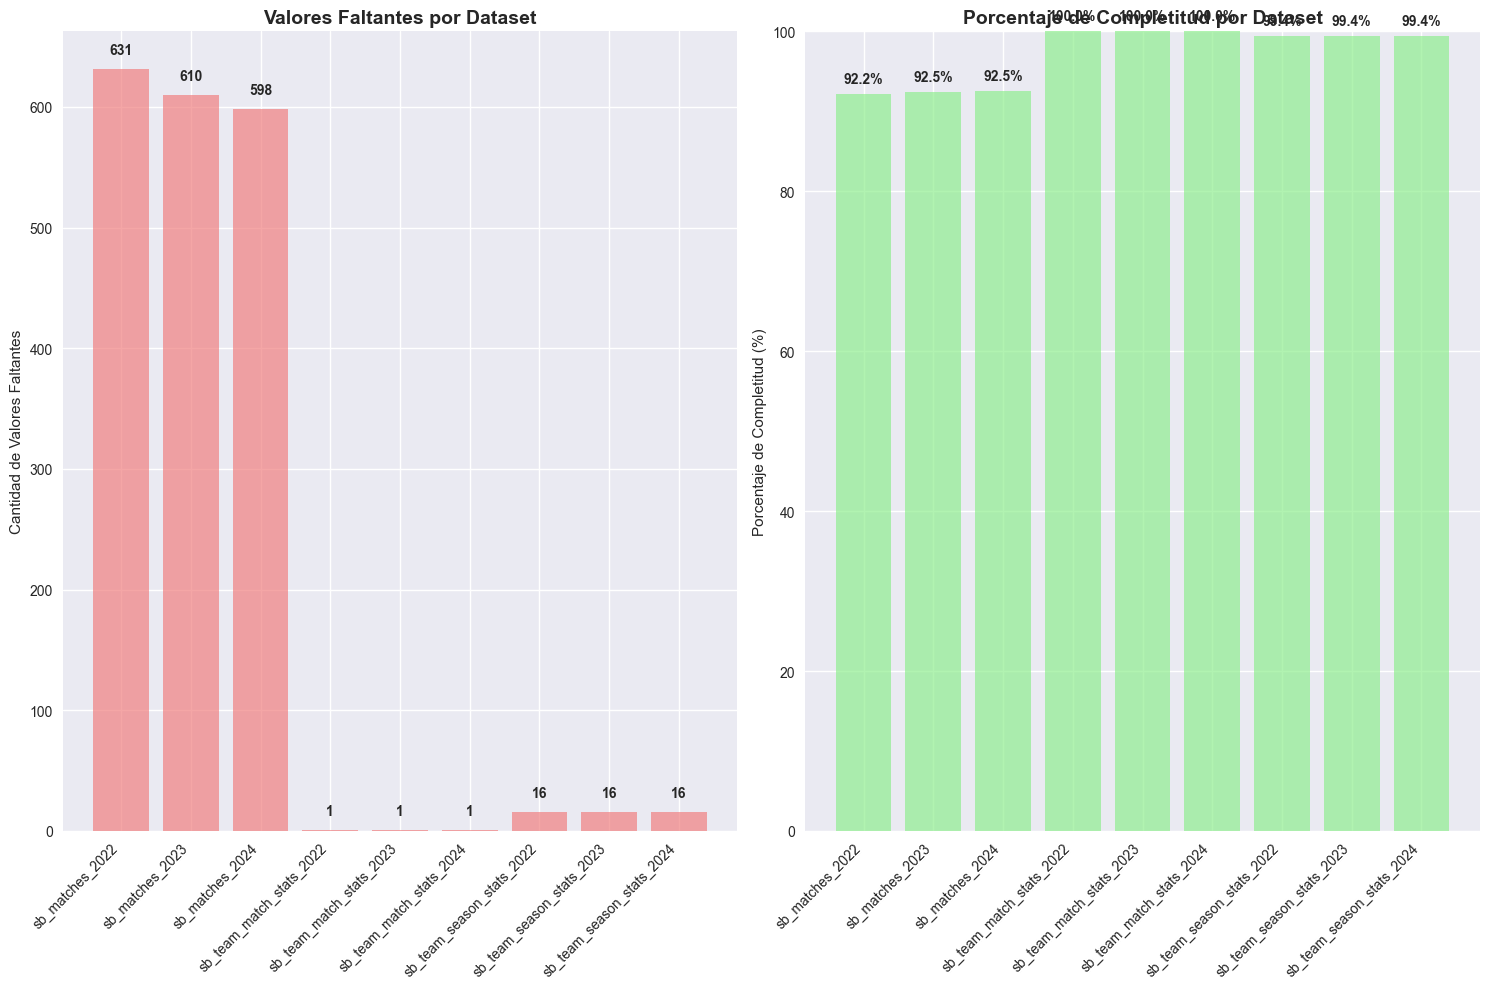

✓ Sección 1 completada exitosamente

2. ANÁLISIS TEMPORAL DE PUNTOS
✓ Figura guardada: analisis_temporal_puntos.png


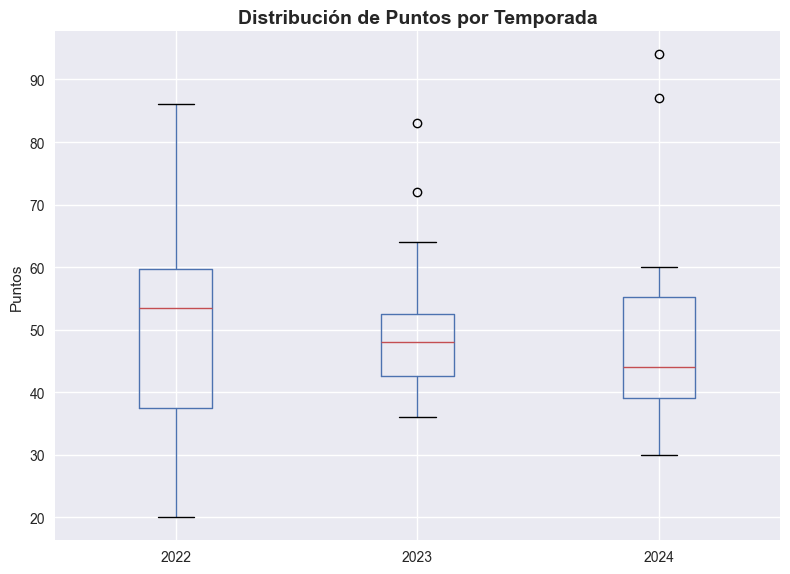

✓ Sección 2 completada exitosamente

3. ANÁLISIS DE RENDIMIENTO POR EQUIPO
✓ Figura guardada: analisis_rendimiento_equipos.png


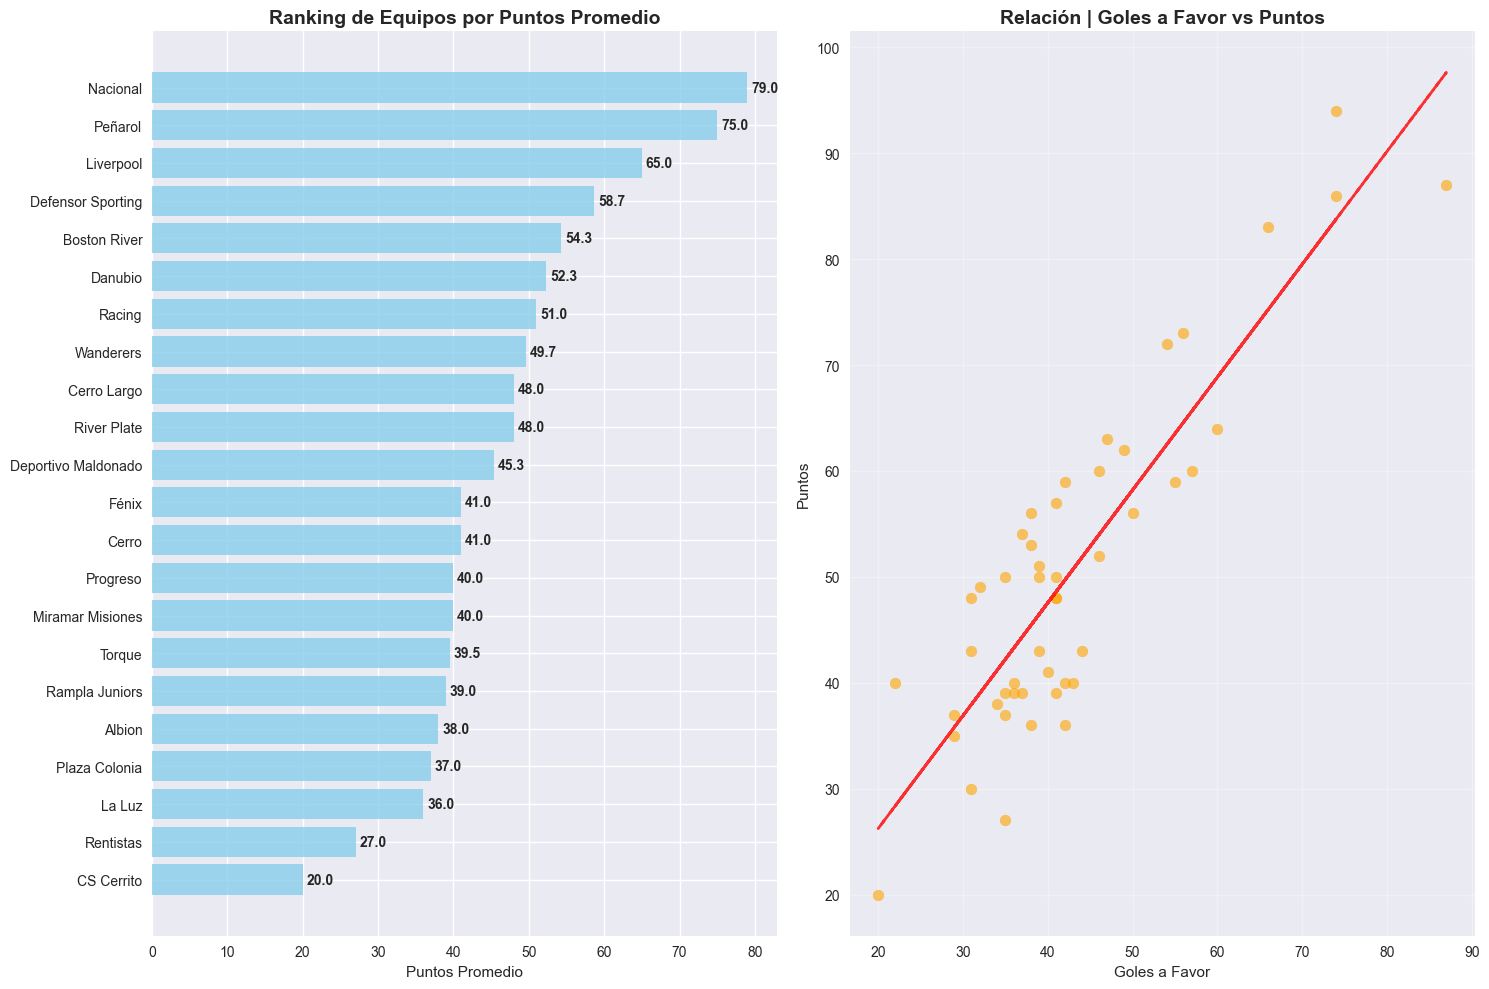

✓ Sección 3 completada exitosamente

4. ANÁLISIS DE PARTIDOS
✓ Figura guardada: analisis_partidos.png


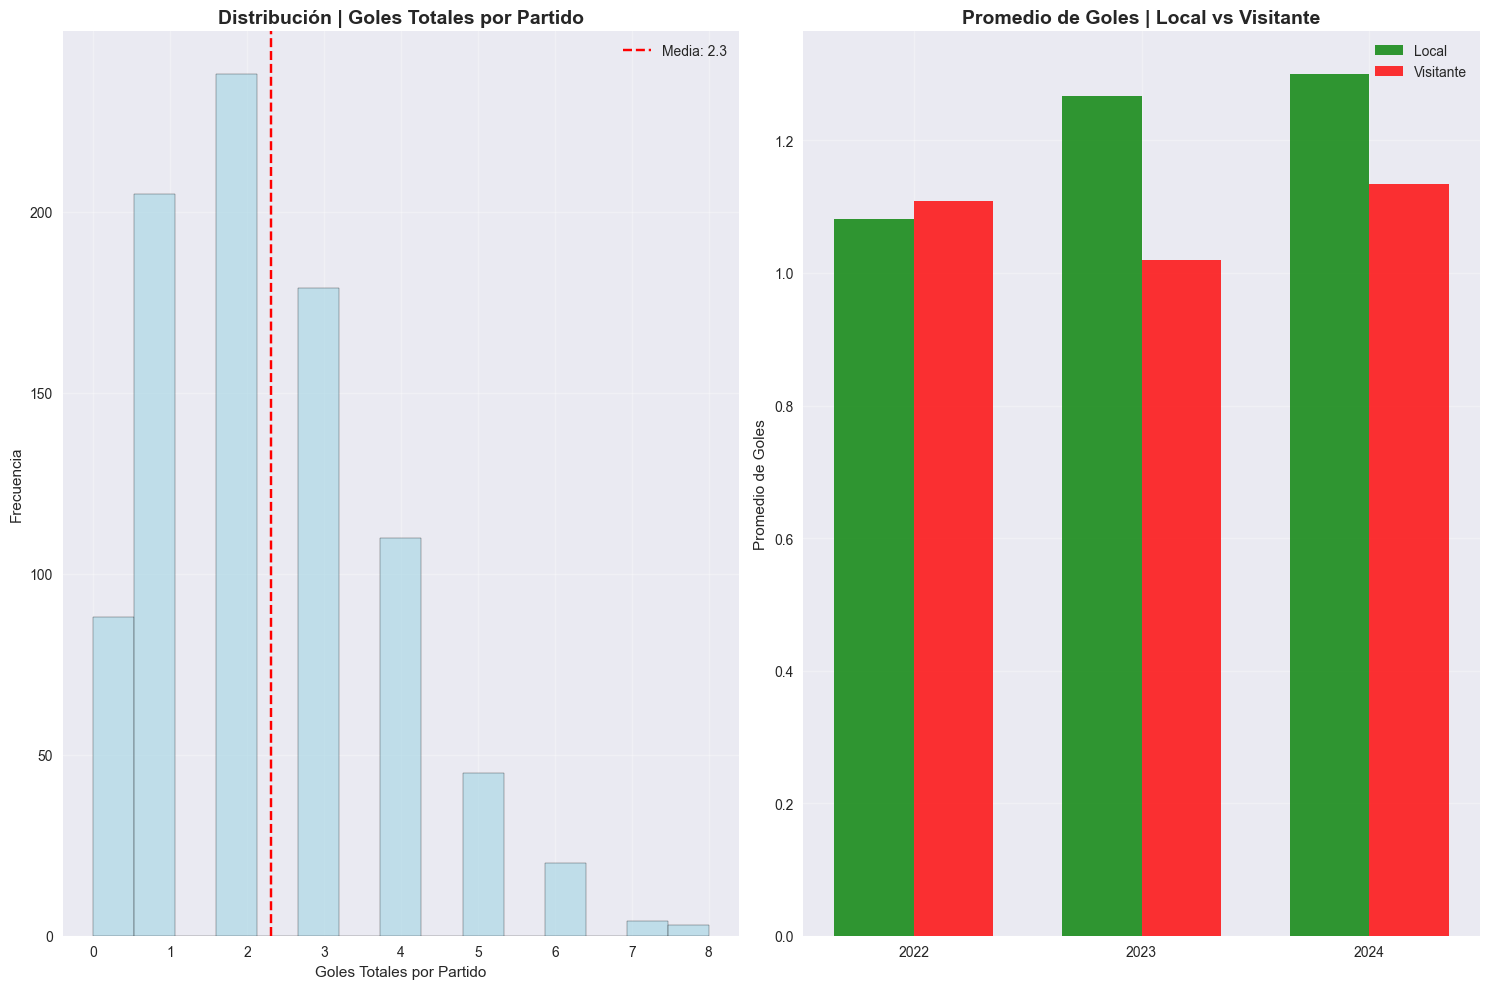

✓ Sección 4 completada exitosamente

5. ANÁLISIS DE CORRELACIONES
✓ Figura guardada: analisis_correlaciones.png


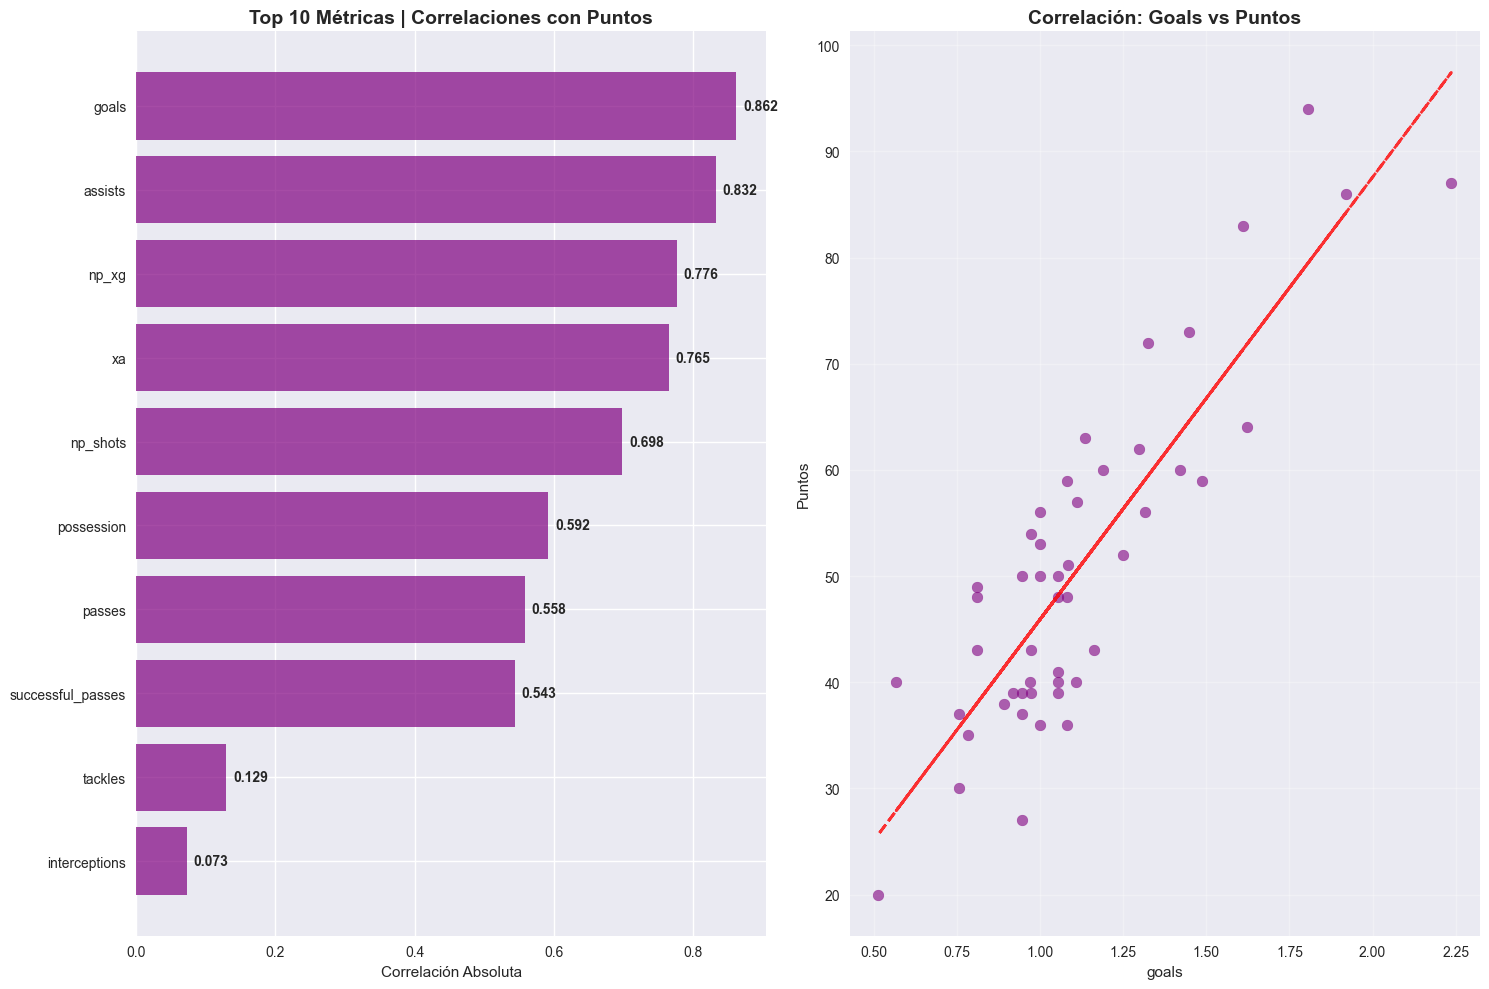

✓ Sección 5 completada exitosamente

🎯 VISUALIZACIONES COMPLETADAS
✓ Se han guardado 5 archivos de imágenes individuales en reports/figures/


In [27]:
# Ejecutar visualizaciones iniciales
visualizaciones_iniciales(datasets)

# 3. Preparación de Datos

## 3.1 Limpieza de Datos

In [ ]:
def limpiar_datos(df):
    """
    Realizar limpieza de datos
    """
    # Implementar limpieza
    pass

## 3.2 Feature Engineering

In [ ]:
def crear_features(df):
    """
    Crear nuevas características
    """
    # Implementar feature engineering
    pass

## 3.3 Preparación para Modelado

In [ ]:
def preparar_datos_modelado(df):
    """
    Preparación final para modelado
    """
    # Implementar preparación final
    pass

# 4. Modelado

## 4.1 Primer Modelo (Especificar tipo)

In [ ]:
def entrenar_modelo(X_train, y_train):
    """
    Entrenar primer modelo
    """
    # Implementar entrenamiento
    pass

# 5. Evaluación

## 5.1 Evaluación Modelo 1

In [ ]:
def evaluar_modelo(modelo, X_test, y_test):
    """
    Evaluar primer modelo
    """
    # Implementar evaluación
    pass

# 6. Despliegue

## 6.1 Preparación para Despliegue

In [ ]:
def preparar_despliegue():
    """
    Preparar modelos para despliegue
    """
    # Implementar preparación
    pass

## 6.2 Documentación de Uso

'''
TODO: Documentar:
- Cómo usar los modelos
- Requerimientos
- Limitaciones
- Mantenimiento necesario
'''

# 7. Conclusiones y Recomendaciones
'''
TODO: Documentar:
- Resultados principales
- Interpretación deportiva
- Limitaciones encontradas
- Mejoras propuestas
- Aplicaciones prácticas
'''


if __name__ == "__main__":
    # Ejecución principal
    print("Iniciando análisis...")